In [1]:
from intermine.webservice import Service
import numpy as np
import scipy.io
import seaborn as sns
from scipy import stats, optimize, interpolate
import pandas as pd
from collections import defaultdict 
import math
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
from scipy import stats
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import os, fnmatch





In [40]:
## Collecting data

## curated data set on interactions in budding yeast SGD downloads
data_raw_interact=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\data_sgd\interaction-filtered-data.xlsx',header=0,encoding="utf-8-sig")
##curated data on slim go terms in budding yeast SGD downloads
data_raw_slim_go=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\data_sgd\slim-goterms-filtered-data.xlsx',header=0,encoding="utf-8-sig")

## published data from sgd from constanzo SGA 2010
data_int_score=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\SGA-Boone-LAB\Costanzo2010-StringentCutoff.tab\genetic-interaction-score-dataset-constanzo.xlsx',header=4,encoding="utf-8-sig")

## published data in the cellmap.org 2016 
data_fitness_sga=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\SGA-Boone-LAB\Data File S1. Raw genetic interaction datasets_ Pair-wise interaction format\Data-fitness.xlsx',header=0,sheet_name='NxN')

#essential genes in WT
annotated_essentials=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Esssential-genes-cerevisae\Essential-genes-yeast.xlsx',header=0,encoding="utf-8-sig")


In [38]:
## Load dataset from queries to yeastmine
data_synthetic_lethals=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Functions\version-control-functions\data-from-yeastmine-queries\data_synthetic_lethals_from_list_yeastmine.xlsx',header=2)
data_synthetic_lethals.drop(['Unnamed: 0'],axis=1)

data_negative_genetic=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Functions\version-control-functions\data-from-yeastmine-queries\data_negative_genetic_from_list_yeastmine.xlsx',header=2)
data_negative_genetic.drop(['Unnamed: 0'],axis=1)

data_dosage_rescue=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Functions\version-control-functions\data-from-yeastmine-queries\data_dosage_rescue_from_list_yeastmine.xlsx',header=2)
data_dosage_rescue.drop(['Unnamed: 0'],axis=1)

data_dosage_lethality=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Functions\version-control-functions\data-from-yeastmine-queries\data_dosage_lethality_from_list_yeastmine.xlsx')
data_dosage_lethality.drop(['Unnamed: 0'],axis=1)

data_phenotypic_suppression=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\Functions\version-control-functions\data-from-yeastmine-queries\data_phenotypic_suppression_from_list_yeastmine.xlsx',header=2)
data_phenotypic_suppression.drop(['Unnamed: 0'],axis=1)


,name,interactor,type,annotation,experiment
0,ACT1,BNI1,genetic,manually curated,"Yoshiuchi S, et al. (2006)-16547104-Phenotypic..."
1,ACT1,CCT4,genetic,manually curated,Vinh DB and Drubin DG (1994)-7916461-Phenotypi...
2,ACT1,FPK1,genetic,manually curated,Niles BJ and Powers T (2014)-25253719-Phenotyp...
3,ACT1,HOF1,genetic,manually curated,"Norden C, et al. (2004)-15228528-Phenotypic Su..."
4,ACT1,PFY1,genetic,manually curated,"Magdolen V, et al. (1993)-8422937-Phenotypic S..."
...,...,...,...,...,...
77,CDC42,SPO14,genetic,manually curated,"Harkins AL, et al. (2008)-18036176-Phenotypic ..."
78,CDC42,STE20,genetic,manually curated,"Lamson RE, et al. (2002)-11940652-Phenotypic S..."
79,CDC42,STE20,genetic,manually curated,"Richman TJ, et al. (1999)-10358031-Phenotypic ..."
80,CDC42,STE50,genetic,manually curated,"Tatebayashi K, et al. (2006)-16778768-Phenotyp..."


In [41]:
## Changing columns names of high throughput data

data_raw_interact.columns=['Gene', 'Interactor', 'Assay', 'Annotation', 'Notes','Phenotype','Reference-SGD','citation']


data_raw_slim_go.columns=['Gene','gene-id','go-aspect','go-term','go-id','feature-type' ]

data_int_score.columns=['query-orf','query-name','array-orf','array-name','score','std','p-value']

data_fitness_sga.columns=['query-strain','query-allele-name','array-strain','array-allele-name','array-type','score','p-value',
                           'query-fitness','array-fitness','double-fitness','double-fitness-std']
annotated_essentials.columns=['Gene','Organism','Condition','Function']




In [101]:
def get_data_fitness(gene_name):
    """
    Input:
    gene_name= name of the gene of interest in capitals , eg.'BEM1'
    Output:
    dataframe on the fitness for a gene of interest
    """
    data=data_fitness_sga[data_fitness_sga['query-allele-name']==gene_name.casefold()]
    if len(data)==0:
        data=data_fitness_sga[data_fitness_sga['array-allele-name']==gene_name.casefold()]
    for i in np.arange(0,len(data.iloc[:,8])):
        if data.iloc[i,8] > 1 or data.iloc[i,7] > 1 or data.iloc[i,9] >1 :
            data.iloc[i,8]=0
            data.iloc[i,7]=0
            data.iloc[i,9]=0

    return data

def merging_datasets(gene_name,data_to_merge_with_fitness_data):
    """
    Function that allows filtering the fitness dataset from Constanzo 2016, with the gene of interest and interactions of interest
    of the gene of interest
    Inputs:
gene_name= gene on which you want to know the data available , it should be introduced in capitals e.g. 'BEM1'
data_to_merge_with_fitness_data= here is a dataframe on the data on interactors for example we would like to merge with the fitness one to filtered  it 
    Output: a dataframe with the merge information 
    """

    filtered_genes=data_to_merge_with_fitness_data[data_to_merge_with_fitness_data['name']==gene_name]['interactor'].tolist()
    filtered_genes=np.unique(filtered_genes)
    filtered_gene_name=data_to_merge_with_fitness_data[data_to_merge_with_fitness_data['name']==gene_name]

    
    
    merge_data=defaultdict(dict)

    for i in np.arange(0,len(filtered_genes)):

        data_fitness=data_fitness_sga[data_fitness_sga['query-allele-name']==filtered_genes[i].casefold()]
        if len(data_fitness)==0:
            data_fitness=data_fitness_sga[data_fitness_sga['array-allele-name']==filtered_genes[i].casefold()]

        for j in np.arange(0,len(data_fitness.iloc[:,8])):
            if data_fitness.iloc[j,8] > 1 or data_fitness.iloc[j,7] > 1 or data_fitness.iloc[j,9] >1 : ## these are relative growth rates , so this is to avoid large numbers in the datasets, that are non -interpretable data
                data_fitness.iloc[j,8]=0
                data_fitness.iloc[j,7]=0
                data_fitness.iloc[j,9]=0

        data_go=data_raw_slim_go[data_raw_slim_go['Gene']==filtered_genes[i]]

        if len(data_fitness[data_fitness['query-allele-name']==gene_name.casefold()])==0 and len(data_fitness[data_fitness['array-allele-name']==gene_name.casefold()])==0 :
            merge_data['score'][filtered_genes[i]]='info not found'
            merge_data['p-value'][filtered_genes[i]]='info not found'
            merge_data['double-fitness'][filtered_genes[i]]='info not found'
            merge_data['array-fitness'][filtered_genes[i]]='info not found'
            merge_data['query-fitness'][filtered_genes[i]]='info not found'
            

        else:
            if len(data_fitness[data_fitness['query-allele-name']==gene_name.casefold()])==0 :
                merge_data['score'][filtered_genes[i]]=data_fitness[data_fitness['array-allele-name']==gene_name.casefold()].iloc[0,5]
                merge_data['p-value'][filtered_genes[i]]=data_fitness[data_fitness['array-allele-name']==gene_name.casefold()].iloc[0,6]
                merge_data['double-fitness'][filtered_genes[i]]=data_fitness[data_fitness['array-allele-name']==gene_name.casefold()].iloc[0,9]
                merge_data['array-fitness'][filtered_genes[i]]=data_fitness[data_fitness['array-allele-name']==gene_name.casefold()].iloc[0,8]
                merge_data['query-fitness'][filtered_genes[i]]=data_fitness[data_fitness['array-allele-name']==gene_name.casefold()].iloc[0,7]
            else :
                merge_data['score'][filtered_genes[i]]=data_fitness[data_fitness['query-allele-name']==gene_name.casefold()].iloc[0,5]
                merge_data['p-value'][filtered_genes[i]]=data_fitness[data_fitness['query-allele-name']==gene_name.casefold()].iloc[0,6]
                merge_data['double-fitness'][filtered_genes[i]]=data_fitness[data_fitness['query-allele-name']==gene_name.casefold()].iloc[0,9]
                merge_data['array-fitness'][filtered_genes[i]]=data_fitness[data_fitness['query-allele-name']==gene_name.casefold()].iloc[0,8]
                merge_data['query-fitness'][filtered_genes[i]]=data_fitness[data_fitness['query-allele-name']==gene_name.casefold()].iloc[0,7]

        if len(data_go)==0:
            merge_data['go-term-filtered-gene'][filtered_genes[i]]='gene not found'
        else:
            merge_data['go-term-filtered-gene'][filtered_genes[i]]=data_go.iloc[:,3].tolist()

    
        merge_data['experiment-data-from'][filtered_genes[i]]=filtered_gene_name[filtered_gene_name['interactor']==filtered_genes[i]]['experiment'].tolist()
     
    merge_data_pd=pd.DataFrame(merge_data)

        

    return merge_data_pd



In [105]:
merge_data=merging_datasets('BEM1',data_synthetic_lethals)


In [106]:
merge_data_numeric=merge_data[pd.to_numeric(merge_data['score'] ,errors='coerce').notnull()]
merge_data_numeric

,score,p-value,double-fitness,array-fitness,query-fitness,go-term-filtered-gene,experiment-data-from
BBC1,-0.5153,0,0.0931,0.9905,0.6143,"[cell cortex, cytoplasm, cytoskeleton, cytoske...","[Tong AH, et al. (2001)-11743205-Synthetic Let..."
BEM2,-0.0358,279.3,0.4698,0.823,0.6143,"[cell cortex, cellular bud, cytoplasm, membran...","[Gorelik M, et al. (2011)-21489982-Synthetic L..."
BEM4,-0.2027,7.034e-12,0.3039,0.8247,0.6143,"[cytoplasm, nucleus, molecular_function, cytos...","[Mack D, et al. (1996)-8754839-Synthetic Letha..."
BUB3,0.1067,4.754e-10,0.5336,0.695,0.6143,"[chromosome, nucleus, ubiquitin-like protein b...","[Daniel JA, et al. (2006)-16157669-Synthetic L..."
CNB1,-0.0271,192.4,0.5653,0.9643,0.6143,"[other, hydrolase activity, ion binding, phosp...","[Parsons AB, et al. (2004)-14661025-Synthetic ..."
GIM3,-0.0183,320.6,0.5092,0.8587,0.6143,"[cytoplasm, cytoskeletal protein binding, DNA-...","[Tong AH, et al. (2004)-14764870-Synthetic Let..."
HSP82,0.0216,6.823,0,0,0,"[cytoplasm, ATPase activity, hydrolase activit...","[Zhao R, et al. (2005)-15766533-Synthetic Leth..."
MAD2,0.0239,363.2,0.6322,0.9903,0.6143,"[chromosome, endomembrane system, nucleus, mol...","[Daniel JA, et al. (2006)-16157669-Synthetic L..."
MSB1,-0.2596,3.904e-05,0.3461,0.986,0.6143,"[cellular bud, cytoplasm, membrane, mitochondr...",[Bender A and Pringle JR (1991)-1996092-Synthe...
SMI1,-0.1777,9.734e-20,0.2971,0.773,0.6143,"[cellular bud, site of polarized growth, molec...","[Lesage G, et al. (2004)-15166135-Synthetic Le..."


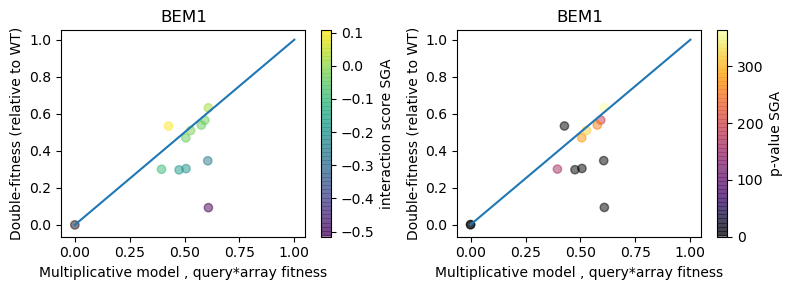

In [108]:
#plt.scatter(score_synt_pd['score'],score_synt_pd['double-fitness'])
gene_name='BEM1'
# merge_data=merging_datasets(gene_name,data_to_merge_with_fitness_data=data_negative_genetic)
# merge_data_numeric=merge_data[pd.to_numeric(merge_data['score'] ,errors='coerce').notnull()]
score_synt_pd=merge_data_numeric
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=100, sharex=True, sharey=True)

plt.subplot(121)
plt.scatter(score_synt_pd['query-fitness']*score_synt_pd['array-fitness'],score_synt_pd['double-fitness'],alpha=0.5, c=score_synt_pd['score'])
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.xlabel('Multiplicative model , query*array fitness')
plt.ylabel('Double-fitness (relative to WT)')
plt.title( gene_name)
plt.colorbar(label='interaction score SGA')
plt.tight_layout()
plt.subplot(122)
plt.scatter(score_synt_pd['query-fitness']*score_synt_pd['array-fitness'],score_synt_pd['double-fitness'],alpha=0.5, c=score_synt_pd['p-value'],cmap='inferno')
plt.plot(np.linspace(0,1),np.linspace(0,1))
plt.xlabel('Multiplicative model , query*array fitness')
plt.ylabel('Double-fitness (relative to WT)')
plt.title( gene_name)
plt.colorbar(label='p-value SGA')
plt.tight_layout()

plt.savefig('merge-data-lethals-and-fitness-of-' + gene_name + '.png',format='png',dpi=300,transparent=True)

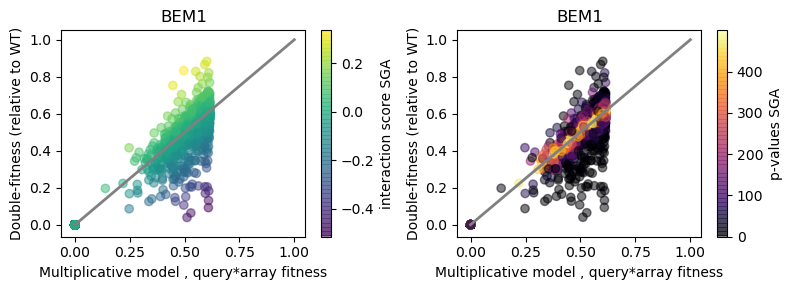

In [109]:
## Visualising from fitness dataset without any merging with the data from synthetic lethals (data_toy_pd)

data_fit=get_data_fitness(gene_name.casefold())
#data=data[data.iloc[:,6]<1] # cutoff for the p-values
fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=100, sharex=True, sharey=True)
plt.subplot(121)
plt.scatter(data_fit.iloc[:,8]*data_fit.iloc[:,7],data_fit.iloc[:,9],alpha=0.5, c=data_fit.iloc[:,5])
plt.plot(np.linspace(0,1),np.linspace(0,1),linewidth=2,color='gray')
plt.colorbar(label='interaction score SGA')
plt.xlabel('Multiplicative model , query*array fitness')
plt.ylabel('Double-fitness (relative to WT)')
plt.title(gene_name)

plt.tight_layout()
plt.subplot(122)

plt.scatter(data_fit.iloc[:,8]*data_fit.iloc[:,7],data_fit.iloc[:,9],alpha=0.5, c=data_fit.iloc[:,6],cmap='inferno')
plt.plot(np.linspace(0,1),np.linspace(0,1),linewidth=2,color='gray')
plt.colorbar(label='p-values SGA')
plt.xlabel('Multiplicative model , query*array fitness')
plt.ylabel('Double-fitness (relative to WT)')
plt.title(gene_name)

plt.tight_layout()

#plt.savefig('data-fitness-correlations-of-' + gene_name + '.png',format='png', dpi=300,transparent=True)

Text(0.5, 1.0, 'Ocurrence of GO-terms for synthetic lethals of CDC24')

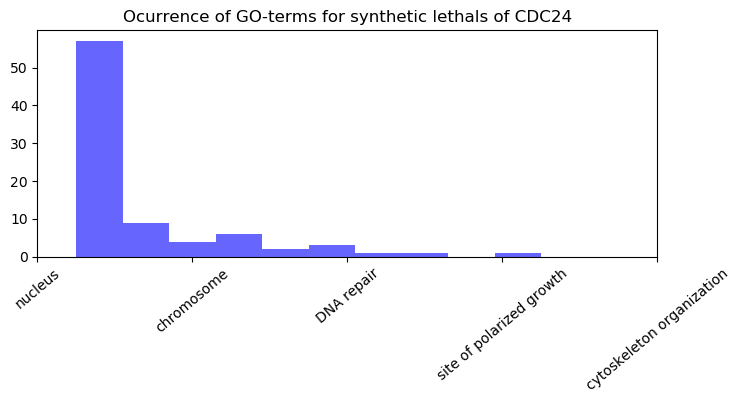

In [107]:
from collections import Counter

go_term_all=[]

for i in np.arange(0,len(data.iloc[:,5])):
   
    go_term_all.append(data.iloc[:,5][i])


out = np.concatenate(go_term_all).ravel()
word_list = out
counts = Counter(word_list)
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

fig, axes = plt.subplots(1, 1, figsize=(8,3), dpi=100, sharex=True, sharey=True)
plt.hist(values,alpha=0.6,color='blue')
#plt.bar(indexes,values)
# add labels
a=np.arange(0,20,4)
labels_xticks=[]
for i in np.arange(0,len(a)): 
    labels_xticks.append(labels[int(a[i])])

plt.xticks(a,labels_xticks,rotation=40)
plt.title('Ocurrence of GO-terms for synthetic lethals of ' + gene_name)


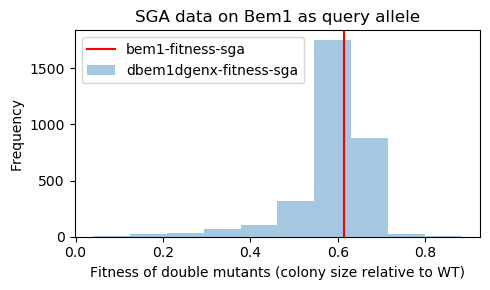

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=100, sharex=True, sharey=True)
#plt.subplots_adjust(bottom=0.2, right=0.5, top=1.4)
#fig.suptitle('SGA data on Bem1 as query allele',x=0.5,y=1.05)


data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['double-fitness'].plot(kind='hist',label='dbem1dgenx-fitness-sga',alpha=0.4)
# data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['double-fitness-std'].plot(kind='hist',label='dbem1dgenx-fitness-sga-std')
bem1_data=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']

plt.axvline(bem1_data['query-fitness'].tolist()[0],color='red',label='bem1-fitness-sga')
plt.legend()
plt.title('SGA data on Bem1 as query allele')
plt.xlabel('Fitness of double mutants (colony size relative to WT)')
# plt.plot(bem1_data['array-allele-name'][0:20],bem1_data['double-fitness'][0:20]),
# plt.plot(bem1_data['array-allele-name'][0:20],bem1_data['score'][0:20]),
plt.tight_layout()
#plt.savefig('double-mutant-fitness-BEM1-query-SGA.png',format='png',dpi=300,transparent=True)

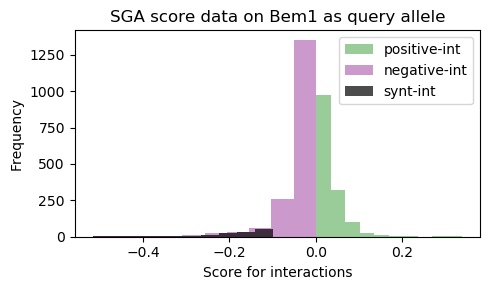

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=100, sharex=True, sharey=True)
#plt.subplots_adjust(bottom=0.2, right=0.5, top=1.4)
#fig.suptitle('SGA data on Bem1 as query allele',x=0.5,y=1.05)


#data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'].plot(kind='hist',label='dbem1dgenx-score-sga',alpha=0.4)
# data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['double-fitness-std'].plot(kind='hist',label='dbem1dgenx-fitness-sga-std')
positive_score=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score']>0
data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'][positive_score[positive_score==True].index].plot(kind='hist',color='green', alpha=0.4,label='positive-int')

negative_score=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score']<0
data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'][negative_score[negative_score==True].index].plot(kind='hist',color='purple', alpha=0.4,label='negative-int')


negative_score=data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score']< -0.1
data_fitness_sga[data_fitness_sga['query-allele-name']=='bem1']['score'][negative_score[negative_score==True].index].plot(kind='hist',color='black', alpha=0.7,label='synt-int')

plt.legend()
plt.title('SGA score data on Bem1 as query allele')
plt.xlabel('Score for interactions')
plt.tight_layout()

plt.tight_layout()
#plt.savefig('score-of-interactors-BEM1-query-SGA.png',format='png',dpi=300,transparent=True)